In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# плохо считывалось из-за формата, пришлось все в строку сделать
cohort_analysis = pd.read_csv('https://stepik.org/media/attachments/lesson/413464/RFM_ht_data.csv', dtype=str)

In [3]:
# меняем цифровой столбец на float
cohort_analysis = cohort_analysis.astype({'Amount': float})

In [4]:
# дату тоже форматируем
cohort_analysis.InvoiceDate = pd.to_datetime(cohort_analysis.InvoiceDate)

In [5]:
# проверяем
cohort_analysis.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [6]:
cohort_analysis

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


# Cohort analysis

In [7]:
# получаем номер недели(может быть месяц и год), когда было совершено действие
cohort_analysis['week_num'] = cohort_analysis.InvoiceDate.dt.isocalendar().week

In [8]:
cohort_analysis.head(2)

,InvoiceNo,CustomerCode,InvoiceDate,Amount,week_num
0,C0011810010001,19067290,2020-09-01,1716.00,36
1,C0011810010017,13233933,2020-09-01,1489.74,36


In [9]:
# найдем когда было совершено первая покупка (в какую неделю)
cohort = cohort_analysis.groupby('CustomerCode', as_index=False).agg(cohort=('week_num', 'min'))

In [10]:
cohort_analysis.shape

(332730, 5)

In [11]:
cohort.shape

(123733, 2)

In [12]:
# объединим таблицы, так к каждому пользователю по всем покупкам прикрепится номер недели, когда была совершена первая покупка
cohort_analysis = cohort_analysis.merge(cohort, on='CustomerCode')

In [13]:
# группируем по когорте и номеру недели совершения покупок, посчитаем кол-во уникальных пользователей
cohort_analysis = cohort_analysis \
                    .groupby(['cohort', 'week_num'], as_index=False) \
                    .agg(quantity=('CustomerCode', 'nunique'))

In [14]:
# теперь найдем периоды, когда были совершены покупки
cohort_analysis['period'] = cohort_analysis.week_num - cohort_analysis.cohort

In [15]:
# сделаем сводную таблцу, в индексах - когорта, колонки - периоды, значения - кол-во пользователей
cohort_analysis = cohort_analysis.pivot_table(index='cohort', columns='period', values='quantity')

In [16]:
# найдем процент по периодам от нулевого периода, разделим по строчно на значения нулевого период
cohort_analysis = cohort_analysis.divide(cohort_analysis[0], axis=0)

In [17]:
cohort_analysis

period,0,1,2,3,4
cohort,,,,,
36,1.0,0.436102,0.435117,0.431432,0.269347
37,1.0,0.315018,0.322745,0.188780,NaN
38,1.0,0.248481,0.147086,NaN,NaN
39,1.0,0.118610,NaN,NaN,NaN
40,1.0,NaN,NaN,NaN,NaN


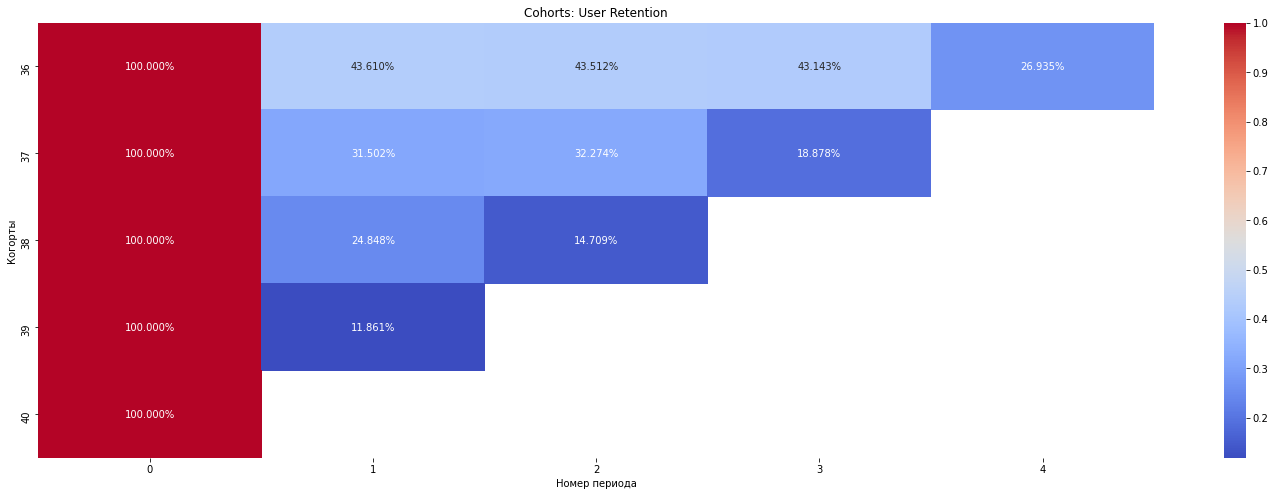

In [19]:
plt.figure(figsize=(25, 8))
sns.heatmap(cohort_analysis, mask=cohort_analysis.isnull(), annot=True, fmt='.3%', cmap='coolwarm')
plt.title('Cohorts: User Retention')
plt.xlabel('Номер периода')
plt.ylabel('Когорты')
plt.show();